In [1]:
### SPARK imports

from pyspark.sql import functions as F
from pyspark.sql.types import DoubleType
from pyspark.sql import Window

from pyspark.ml.regression import LinearRegression
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import VectorAssembler


In [68]:
### Regular python imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb
import getpass
%matplotlib inline

In [3]:
#Set the paths here!

user = getpass.getuser()
if user == "sidsel":
    parquet = "/home/"+user+"/workspace/sparkdata/parquet/"
    regnskabsData = "alleregnskaber.parquet"
    cvrData = "virkdata.parquet"
    csvpath = "/home/"+user+'/workspace/sparkdata/csv'

elif user == "svanhmic":
    cvrParquetPath = "/home/"+user+"/workspace/Python/Erhvervs/data/cdata/parquet/"
    regnskabParquetPath = "/home/"+user+"/workspace/Python/Erhvervs/data/regnskabsdata/sparkdata/parquet/" 
    csvpath = "/home/"+user+'/workspace/Python/Erhvervs/data/regnskabsdata'

In [4]:
zeroYearWindow = Window.partitionBy("cvr")
laggValueWindow = Window.partitionBy("cvr").orderBy("End_Instant")

In [226]:
#import data and do transformations

iktBrancheDf = sqlContext.read.parquet(cvrParquetPath+"IktBrancher.parquet").cache()
notIktGazelleDf = sqlContext.read.parquet(cvrParquetPath+"IktNotGazeller.parquet")
iktGazelleDf = sqlContext.read.parquet(cvrParquetPath+"IktGazeller.parquet")

notIktGazelleDf = (notIktGazelleDf
                   .drop("rank")
                   .withColumn("GrossResult",F.col("GrossResult").cast("double"))
                   .withColumn("Revenue",F.col("Revenue").cast("double"))
                   .withColumn("LaggedGrossResult",F.col("GrossResult")-F.lag(F.col("GrossResult")).over(laggValueWindow))
                   .filter(F.col("LaggedGrossResult") >= 0.0)
                   .withColumn("FirstRevenue",F.when(F.col("Revenue") >= 1000000,True).otherwise(False))
                   .withColumn("FirstGrossResult",F.when(F.col("GrossResult") >= 500000,True).otherwise(False))
                   .filter((F.col("FirstGrossResult")==True) | (F.col("Revenue")==True))
                   .withColumn("Year", F.rank().over(laggValueWindow).cast("double")-1)
                   .withColumn("maxRank",F.max("Year").over(zeroYearWindow).cast("double"))
                   .filter(F.col("maxRank") >= 3) # re want to predict for at least four values
                   .drop("maxRank")
                   #.filter(F.col("cvr") == 10008123)
                   .cache()
               )

print("Number of points: "+str(notIktGazelleDf.count()))
print("Number of cvr-numbers: "+str(notIktGazelleDf.select("cvr").distinct().count()))

#How  many are there in each IKT-subbranche for cvrs with more than a mio or half mio? 
(notIktGazelleDf
 .select("cvr","branchekode","Branchenavn")
 .distinct()
 .groupBy("Branchenavn","branchekode")
 .count()
 .show(truncate=False))

Number of points: 672
Number of cvr-numbers: 110
+-----------------------------------------------------+-----------+-----+
|Branchenavn                                          |branchekode|count|
+-----------------------------------------------------+-----------+-----+
|Engroshandel med elektronisk udstyr                  |465210     |6    |
|Computer facility management                         |620300     |2    |
|Fastnetbaseret telekommunikation                     |611000     |11   |
|Fremstilling af elektronik til husholdninger         |264000     |1    |
|Engroshandel med computere, ydre enheder og software |465100     |21   |
|Databehandling, webhosting og lignende serviceydelser|631100     |5    |
|Reparation af kommunikationsudstyr                   |951200     |1    |
|Fremstilling af kommunikationsudstyr                 |263000     |3    |
|Anden udgivelse af software                          |582900     |5    |
|Computerprogrammering                                |620100  

In [227]:
notIktGazelleDf.show()

+--------+-----------+-------+-----------+-----------+---------------+-----------+--------------------+--------------------+---------------------+--------------------+-----------------+------------+----------------+----+
|     cvr|branchekode|unitRef|End_Instant|GrossResult|GrossProfitLoss|    Revenue|        branchetekst|         Branchenavn|Standardgruppering_19|         IKT-områder|LaggedGrossResult|FirstRevenue|FirstGrossResult|Year|
+--------+-----------+-------+-----------+-----------+---------------+-----------+--------------------+--------------------+---------------------+--------------------+-----------------+------------+----------------+----+
|25476255|     631100|    DKK| 2014-06-30| 5.251484E7|    5.2514844E7|7.1780952E7|Informationstjene...|Databehandling, w...| Information og ko...|IKT-service, kons...|       5.251484E7|        true|            true| 0.0|
|25476255|     631100|    DKK| 2015-06-30|   5.5079E7|            0.0|7.7901472E7|Informationstjene...|Databehandlin

In [ ]:
pandasNotGazeller = (notIktGazelleDf
                     .select("cvr","branchekode","Branchenavn","GrossResult","Revenue",F.year(F.col("End_Instant")).alias("Year"))
                     .filter((F.col("branchekode") == 620100) | (F.col("branchekode") == 620200) )
                     .toPandas()
                    )
#sb.set_style("ticks")
#g = sb.FacetGrid(pandasNotGazeller,hue="branchekode",legend_out=True,size=8,)
#g.set(yscale="log")
##g.map(plt.scatter,"Year","GrossResult")
#g.map(plt.plot,"Year","GrossResult")

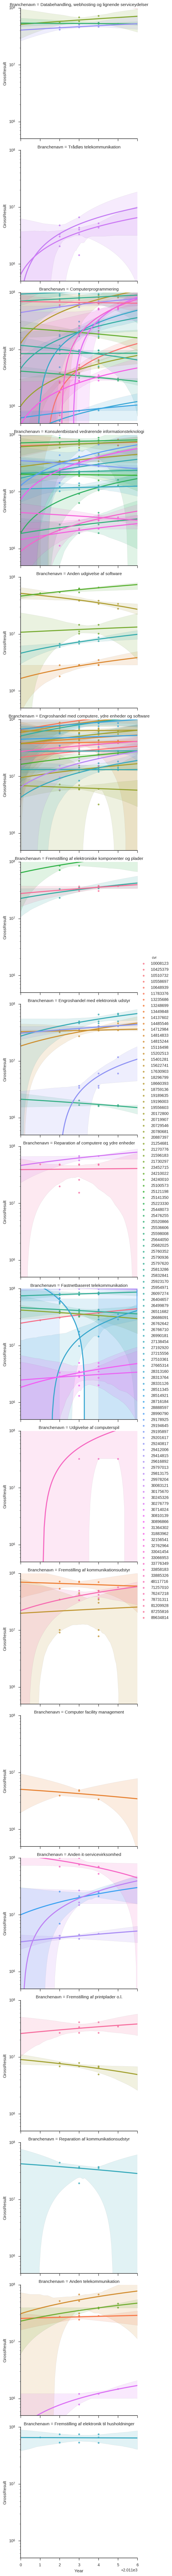

In [231]:


ax = sb.lmplot("Year","GrossResult",pandasNotGazeller,fit_reg=True,hue="cvr",sharex=True,logx=False,legend=True,size=5,row="Branchenavn")
#ax.map(plt.plot,"Year","GrossResult")
ax.set(yscale="log")
ax.set(ylim=[500000,100000000])
plt.show()

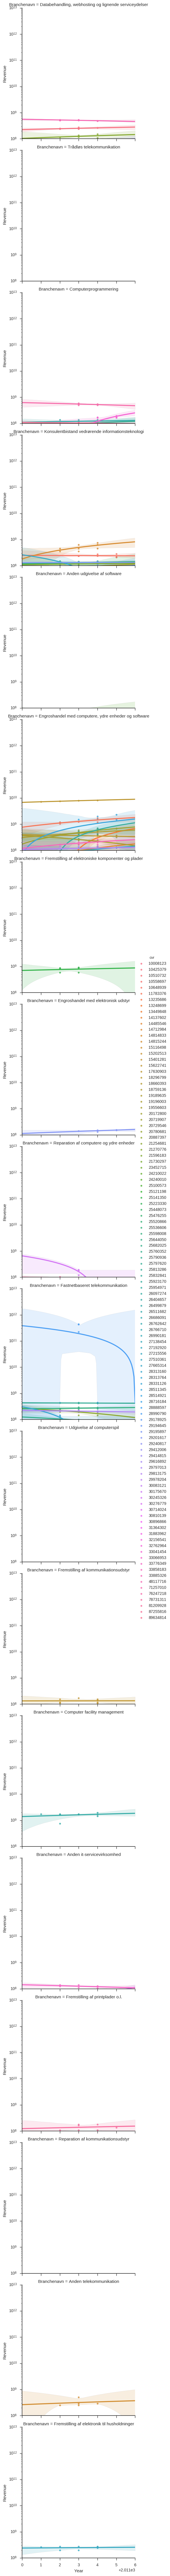

In [232]:
ax2 = sb.lmplot("Year","Revenue",pandasNotGazeller,fit_reg=True,hue="cvr",sharex=True,logx=False,legend=True,size=5,row="Branchenavn")
#ax.map(plt.plot,"Year","GrossResult")
ax2.set(yscale="log")
plt.show()

In [173]:
#Build the pipeline here!


vecAss = VectorAssembler(inputCols=["Year"],outputCol="features")
lg = LinearRegression(labelCol="GrossResult",regParam=0.1,elasticNetParam=0.1)
pipeGro = Pipeline(stages=[vecAss,lg])

lg2 = LinearRegression(labelCol="Revenue",regParam=0.1,elasticNetParam=0.1)
pipeRev = Pipeline(stages=[vecAss,lg2])

In [160]:
paramGrid = (ParamGridBuilder()
             .baseOn({lg.maxIter:10})
             
             .baseOn({lg.featuresCol:vecAss.getOutputCol()})     
             .addGrid(lg.elasticNetParam, [0.5])
             .addGrid(lg.regParam,[0.1])
             .build())


crossvalGro = CrossValidator(estimator=pipeGro,
                          estimatorParamMaps=paramGrid,
                          evaluator=RegressionEvaluator(),
                          numFolds=2)  # use 3+ folds in practice

In [208]:
def executeLinearRegressionsYearVar(df,targetCol,crossval,maxYear=6):
    """
        this method should do linear regression for 
        each of the companies or another column that we can chose. 
    """
    
    #Extract unqiue cvr-numbers
    uniqueTargetValues = (df
                          .select(targetCol)
                          .distinct()
                          .rdd
                          .map(lambda x: x[0])
                          .collect()
                         )
    
    modelsPrCvr = {} # add all models with cvr numbers in this one.
    
    #yearDf = sqlContext.range(1,maxYear).withColumnRenamed("id","Year").cache()
    
    #Run through all cvr-numbers
    for company in uniqueTargetValues:
        try:
            tempDf = df.filter(F.col(targetCol) == company)
            #tempDf.show(5)
            if tempDf.count() < 3:
                print("this should not happen: "+str(tempDf.count()))
            else:
                model = crossval.fit(tempDf) # create model             
                
                modelsPrCvr[company] = model
        except:
            tempDf.show()
            #tempDf.printSchema()
            #break

    
    return modelsPrCvr
    
def evaluateAllModels(df,colName,dict,evaluator):
    """
        this method should do linear regression for 
        each of the companies or another column that we can chose. 
    """
    
    
    yearDf = sqlContext.range(0,6).withColumnRenamed("id","Year").cache()
    dictDf = {}
    
    for idx,val in dict.items():
        
        tempDf = df.filter(F.col(colName) == idx)
        prediction = val.transform(tempDf)

        dictDf[idx] = (evaluator.evaluate(prediction),val.transform(yearDf),hasIncreasedtoDouble(val.transform(yearDf)))
    return dictDf




def hasIncreasedtoDouble(prediction,startYear=0,endYear=4):
    """
        returns try or false to wheter if a company has more than doubled its size in revenue or grossResult
    """
    
    zeroVal = prediction.filter(F.col("Year") == startYear).collect()[0]["prediction"]
    endVal = prediction.filter(F.col("Year") == endYear).collect()[0]["prediction"]
    if endVal >= (zeroVal*2):
        return True
    else: 
        return False
    

In [162]:
print("entire IKT: " + str(iktBrancheDf.count()))
print("gazels in IKT: " + str(iktGazelleDf.count()))
print("Non-gazels in IKT: " + str(notIktGazelleDf.count()))

entire IKT: 41410
gazels in IKT: 383
Non-gazels in IKT: 672


In [163]:
#notIktGazelleDf.show()

In [181]:
# Run cross-validation, and choose the best set of parameters.
allModelsRev = executeLinearRegressionsYearVar(notIktGazelleDf,"cvr",pipeRev)
allModelsGro = executeLinearRegressionsYearVar(notIktGazelleDf,"cvr",pipeGro)

In [182]:
regressionEvaluatorGro = RegressionEvaluator(predictionCol="prediction",labelCol="GrossResult",metricName="rmse")
regressionEvaluatorRev = RegressionEvaluator(predictionCol="prediction",labelCol="Revenue",metricName="rmse")


In [183]:
modelsDictRev = evaluateAllModels(notIktGazelleDf,"cvr",allModelsRev,regressionEvaluatorRev)
modelsDictGro = evaluateAllModels(notIktGazelleDf,"cvr",allModelsGro,regressionEvaluatorGro)

In [197]:
filtered_Rev = {k:v for (k,v) in modelsDictRev.items() if v[2] == True}
filtered_Gross = {k:v for (k,v) in modelsDictGro.items() if v[2] == True}

In [198]:
#predicted Gazeller for IKT GrossResult
filtered_Gross
    

{10008123: (32407077.86006895,
  DataFrame[Year: bigint, features: vector, prediction: double],
  True),
 10510732: (28231176.870766405,
  DataFrame[Year: bigint, features: vector, prediction: double],
  True),
 13248699: (324113761.827796,
  DataFrame[Year: bigint, features: vector, prediction: double],
  True),
 13449848: (65311766.719328605,
  DataFrame[Year: bigint, features: vector, prediction: double],
  True),
 14712984: (1835134.65350852,
  DataFrame[Year: bigint, features: vector, prediction: double],
  True),
 15116498: (37460054.007166654,
  DataFrame[Year: bigint, features: vector, prediction: double],
  True),
 15202513: (34276646.09569768,
  DataFrame[Year: bigint, features: vector, prediction: double],
  True),
 15401281: (45673904.83573575,
  DataFrame[Year: bigint, features: vector, prediction: double],
  True),
 18660393: (80103906.19792937,
  DataFrame[Year: bigint, features: vector, prediction: double],
  True),
 19189635: (35767854.909587935,
  DataFrame[Year: bigi

In [199]:
#predicted Gazeller for IKT Revenue
filtered_Rev

{10008123: (0.0,
  DataFrame[Year: bigint, features: vector, prediction: double],
  True),
 10510732: (0.0,
  DataFrame[Year: bigint, features: vector, prediction: double],
  True),
 13248699: (131049026.44266193,
  DataFrame[Year: bigint, features: vector, prediction: double],
  True),
 13449848: (0.0,
  DataFrame[Year: bigint, features: vector, prediction: double],
  True),
 14712984: (857860.4027394229,
  DataFrame[Year: bigint, features: vector, prediction: double],
  True),
 15116498: (0.0,
  DataFrame[Year: bigint, features: vector, prediction: double],
  True),
 15202513: (0.0,
  DataFrame[Year: bigint, features: vector, prediction: double],
  True),
 15401281: (68449769.38319084,
  DataFrame[Year: bigint, features: vector, prediction: double],
  True),
 18660393: (0.0,
  DataFrame[Year: bigint, features: vector, prediction: double],
  True),
 19189635: (0.0,
  DataFrame[Year: bigint, features: vector, prediction: double],
  True),
 20172800: (0.0,
  DataFrame[Year: bigint, feat

In [188]:
### regression pr branche? 

In [211]:
allModelsForBrancheRev = executeLinearRegressionsYearVar(notIktGazelleDf,"branchekode",pipeRev)
allModelsForBrancheGro = executeLinearRegressionsYearVar(notIktGazelleDf,"branchekode",pipeGro)
#allModelsGro = executeLinearRegressionsYearVar(notIktGazelleDf,"cvr",pipeGro)

In [212]:

modelsDictRevBrancher = evaluateAllModels(notIktGazelleDf,"branchekode",allModelsForBrancheRev,regressionEvaluatorRev)
modelsDictGroBrancher = evaluateAllModels(notIktGazelleDf,"branchekode",allModelsForBrancheGro,regressionEvaluatorGro)


filtered_RevBrancher = {k:v for (k,v) in modelsDictRevBrancher.items() if v[2] == True}
filtered_GrossBrancher = {k:v for (k,v) in modelsDictGroBrancher.items() if v[2] == True}

In [219]:
modelsDictGroBrancher["261100"][0].show()

AttributeError: 'float' object has no attribute 'show'

In [201]:
debtDf =sqlContext.read.parquet(regnskabParquetPath+"regnskaberDebt.parquet")
debtDf.show()
#debtCol = list(map(lambda x: x[0],debtDf.collect()))

#whos in it?

+--------------------+---+----+----+-------+----------+----------------+----------+-----------+----------+--------------------+--------------+--------------------+
|                Name|Dec|Prec|Lang|unitRef|contextRef|EntityIdentifier|     Start|End_Instant|     Value|          Dimensions|originalLength|           DebtNames|
+--------------------+---+----+----+-------+----------+----------------+----------+-----------+----------+--------------------+--------------+--------------------+
|fsa:OtherLongterm...| -3|null|null|    DKK|  16993085|        16993085|      null| 2014-09-30|21,196,000|[cmn:Consolidated...|            10|DebtRaisedByIssua...|
|fsa:ShorttermDebt...| -3|null|null|    DKK|  16993085|        16993085|      null| 2014-09-30|         0|[cmn:Consolidated...|             1|         DebtToBanks|
|fsa:OtherLongterm...| -3|null|null|    DKK|  16993085|        16993085|      null| 2013-09-30|32,874,000|[cmn:Consolidated...|            10|DebtRaisedByIssua...|
|fsa:ShorttermDe